# V. Weather Predictions: 'Classic' Machine Learning Models Vs Keras

There's no shortage of online tutorials on specific data science tasks. What's harder to find are tutorials that connect the dots for newcomers, and help them explore the next phase once they've build up some level of familiarity in an area, say, machine learning basics.

After spending a good part of 2019 learning the basics of machine learning, I was keen to start experimenting with some rudimentary deep learning. But there wasn't an obvious way to start. So I decided to pull together the materials I had found on the subject, and rustled up a series of notebooks that would hopefully help others who are looking to do the same.

In these notebooks, I use a mix of machine learning and deep learning techniques to try to predict the rain pattern in Singapore in December 2019 (validation set). The models will be trained on 37 years of weather data in Singapore, from Jan 01 1983 to the end of November in 2019. 

CAVEAT: While this dataset spans 37 years, it contains just under 13,500 rows of data. It is fair to ask whether you need deep learning for a dataset like this, and whether it necessarily produces better results.

Frankly, these questions don't matter much to me as a newcomer to data science. Massive real-world datasets are hard to come by, especially in Singapore. I much prefer to continue experimenting and learning new techniques, instead of waiting for the perfect dataset to drop on my lap.

# PART 3: KERAS TUNER

Aside from using scikit-learn's features to tune a Keras model, you can also use the relatively new Keras Tuner. Here's the [official documentation](https://keras-team.github.io/keras-tuner/), and two super helpful tutorials ([here](https://medium.com/python-data/hyperparameter-tuning-tensorflow-2-models-with-keras-tuner-81f36f801040) and [here](https://www.curiousily.com/posts/hackers-guide-to-hyperparameter-tuning/)) from which this notebook is based.

The results I achieved with this approach were the poorest of the lot, but I chalk it up to my lack of experience with Keras and deep learning in general. But it's an approach I'll certainly try again in other projects.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function, unicode_literals

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner import HyperModel, HyperParameters
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

%matplotlib inline
mpl.rcParams["figure.dpi"] = 300
%config InlineBackend.figure_format ='retina'

# 1. DATA PRE-PROCESSING

## 1.1 CREATE TARGET COLUMN 

In [4]:
# loading the dataset prepared in notebook 5.0

weather = pd.read_csv('../data/weather_model.csv')

In [5]:
# Creating a new target column
# To keep the project simple, I'll focus on predicting rainfall at a binary level - rain (1), or no rain (0)

weather['Rain_Or_Not'] = np.where(weather['Daily Rainfall Total (mm)'] > 0, 1, 0)

In [6]:
# 52.2% days with no rain, 47.8 rainy days
# The target values are slightly imbalanced in distribution, but not egregiously so
# I won't take additional steps to balance out the distribution, but feel free to consider options like SMOTE

weather['Rain_Or_Not'].value_counts()

0    7036
1    6447
Name: Rain_Or_Not, dtype: int64

In [7]:
weather.head()

,Date,Year,Month,Day,Daily Rainfall Total (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Rain_Or_Not
0,2019-11-30,2019,11,30,9.4,27.6,32.1,25.0,6.8,28.1,1
1,2019-11-29,2019,11,29,73.4,26.5,32.0,24.0,6.1,31.3,1
2,2019-11-28,2019,11,28,9.0,27.8,31.4,25.3,7.6,27.4,1
3,2019-11-27,2019,11,27,1.8,27.5,31.5,25.4,7.2,31.3,1
4,2019-11-26,2019,11,26,0.0,28.5,33.0,25.7,10.4,34.9,0


### NOTE: 
I've left the outliers *in* in this dataset, so as to give the models the maximum amount of information possible. In dealing with actual work-place projects, there should be a serious discussion about how many outliers to remove, and the trade-offs involved.

## 1.2 TRAIN-TEST-SPLIT TRAINING DATA

In [8]:
X = weather[
    [
        "Mean Temperature (°C)",
        "Maximum Temperature (°C)",
        "Minimum Temperature (°C)",
        "Mean Wind Speed (km/h)",
        "Max Wind Speed (km/h)",
    ]
]

y = weather["Rain_Or_Not"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# 2. KERAS TUNER - CREATE A HYPERMODEL SUBCLASS

There are at least 4 tuners to choose from, but I'll just run 2 in this notebook: Hyperband and RandomSearch.

Using a HyperModel subclass makes it easier to test out the two tuners in succession. The code below is adapted from online posts by [Bernard Brenyah](https://github.com/PyDataBlog/Python-for-Data-Science/blob/master/Tutorials/divorce_tuner.py) and [Venelin Valkov](https://www.curiousily.com/posts/hackers-guide-to-hyperparameter-tuning/), with minor modifications. 

In [10]:
class Keras_HyperModel(HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):

        # specify model
        model = Sequential()

        model.add(keras.layers.Dense(units=512, input_dim=5, activation="relu"))

        # range of models to build
        for i in range(hp.Int("num_layers", 1, 10)):
            model.add(
                layers.Dense(
                    units=hp.Int(
                        "units_" + str(i), min_value=16, max_value=256, step=8
                    ),
                    activation="relu",
                )
            )

        model.add(
            layers.Dropout(
                rate=hp.Choice(
                    "drop_rate_" + str(i),
                    [0.01, 0.1, 0.2, 0.3],
                )
            )
        )

        model.add(layers.Dense(self.num_classes, activation="sigmoid"))

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4]),
                hp.Choice("momentum", [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]),
            ),
            loss="binary_crossentropy",
            metrics=["accuracy"],
        )

        return model


hypermodel = Keras_HyperModel(num_classes=1)


## 2.1 KERAS TUNER - HYPERBAND

The Hyperband tuner starts with random sampling at first, but then moves ahead only with the best performing candidates from the initial results.

In [11]:
tuner = Hyperband(
    hypermodel,
    objective='accuracy',
    max_epochs=20,
    seed=42,
    project_name='weather_keras') # detailed logs, checkpoints in this folder

In [12]:
tuner.search(
    X_train.values,
    y_train.values.flatten(),
    epochs=20,
    validation_data=(X_test.values, y_test.values.flatten()),
)


Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 5:33 - loss: 0.6862 - accuracy: 0.50 - ETA: 12s - loss: 0.6935 - accuracy: 0.5060 - ETA: 6s - loss: 0.6921 - accuracy: 0.518 - ETA: 3s - loss: 0.6891 - accuracy: 0.53 - ETA: 2s - loss: 0.6879 - accuracy: 0.54 - ETA: 1s - loss: 0.6821 - accuracy: 0.55 - ETA: 1s - loss: 0.6760 - accuracy: 0.56 - ETA: 1s - loss: 0.6689 - accuracy: 0.57 - ETA: 0s - loss: 0.6653 - accuracy: 0.58 - ETA: 0s - loss: 0.6619 - accuracy: 0.59 - ETA: 0s - loss: 0.6568 - accuracy: 0.60 - ETA: 0s - loss: 0.6550 - accuracy: 0.60 - ETA: 0s - loss: 0.6496 - accuracy: 0.61 - ETA: 0s - loss: 0.6459 - accuracy: 0.61 - 2s 175us/sample - loss: 0.6439 - accuracy: 0.6193 - val_loss: 0.6111 - val_accuracy: 0.6674
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.8429 - accuracy: 0.56 - ETA: 0s - loss: 0.6308 - accuracy: 0.64 - ETA: 0s - loss: 0.6122 - accuracy: 0.66 - ETA: 0s - loss: 0.6035 - 

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:31 - loss: 0.6797 - accuracy: 0.65 - ETA: 8s - loss: 0.7330 - accuracy: 0.5226 - ETA: 4s - loss: 0.7103 - accuracy: 0.56 - ETA: 3s - loss: 0.7054 - accuracy: 0.56 - ETA: 2s - loss: 0.6926 - accuracy: 0.58 - ETA: 1s - loss: 0.6892 - accuracy: 0.58 - ETA: 1s - loss: 0.6846 - accuracy: 0.59 - ETA: 1s - loss: 0.6763 - accuracy: 0.60 - ETA: 1s - loss: 0.6755 - accuracy: 0.60 - ETA: 1s - loss: 0.6714 - accuracy: 0.60 - ETA: 0s - loss: 0.6645 - accuracy: 0.61 - ETA: 0s - loss: 0.6597 - accuracy: 0.61 - ETA: 0s - loss: 0.6556 - accuracy: 0.62 - ETA: 0s - loss: 0.6509 - accuracy: 0.62 - ETA: 0s - loss: 0.6470 - accuracy: 0.63 - ETA: 0s - loss: 0.6437 - accuracy: 0.63 - ETA: 0s - loss: 0.6423 - accuracy: 0.63 - ETA: 0s - loss: 0.6418 - accuracy: 0.63 - ETA: 0s - loss: 0.6418 - accuracy: 0.63 - 2s 150us/sample - loss: 0.6407 - accuracy: 0.6393 - val_loss: 0.6139 - val_accuracy: 0.6800


Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:25 - loss: 1.1971 - accuracy: 0.40 - ETA: 5s - loss: 0.7120 - accuracy: 0.5694 - ETA: 5s - loss: 0.7052 - accuracy: 0.57 - ETA: 3s - loss: 0.6860 - accuracy: 0.59 - ETA: 2s - loss: 0.6724 - accuracy: 0.60 - ETA: 1s - loss: 0.6646 - accuracy: 0.61 - ETA: 1s - loss: 0.6588 - accuracy: 0.62 - ETA: 1s - loss: 0.6544 - accuracy: 0.62 - ETA: 0s - loss: 0.6456 - accuracy: 0.63 - ETA: 0s - loss: 0.6428 - accuracy: 0.63 - ETA: 0s - loss: 0.6367 - accuracy: 0.64 - ETA: 0s - loss: 0.6333 - accuracy: 0.64 - ETA: 0s - loss: 0.6297 - accuracy: 0.65 - ETA: 0s - loss: 0.6275 - accuracy: 0.65 - ETA: 0s - loss: 0.6255 - accuracy: 0.65 - ETA: 0s - loss: 0.6223 - accuracy: 0.65 - 2s 141us/sample - loss: 0.6211 - accuracy: 0.6577 - val_loss: 0.6520 - val_accuracy: 0.6392
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.7138 - accuracy: 0.56 - ETA: 0s - loss: 0.6067 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:27 - loss: 0.9477 - accuracy: 0.56 - ETA: 5s - loss: 0.6964 - accuracy: 0.6105 - ETA: 2s - loss: 0.6864 - accuracy: 0.59 - ETA: 1s - loss: 0.6715 - accuracy: 0.61 - ETA: 1s - loss: 0.6606 - accuracy: 0.62 - ETA: 0s - loss: 0.6495 - accuracy: 0.63 - ETA: 0s - loss: 0.6463 - accuracy: 0.63 - ETA: 0s - loss: 0.6420 - accuracy: 0.63 - ETA: 0s - loss: 0.6393 - accuracy: 0.63 - ETA: 0s - loss: 0.6364 - accuracy: 0.64 - ETA: 0s - loss: 0.6353 - accuracy: 0.64 - ETA: 0s - loss: 0.6312 - accuracy: 0.64 - ETA: 0s - loss: 0.6310 - accuracy: 0.64 - 1s 121us/sample - loss: 0.6303 - accuracy: 0.6475 - val_loss: 0.5849 - val_accuracy: 0.6856
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.5692 - accuracy: 0.68 - ETA: 0s - loss: 0.6063 - accuracy: 0.64 - ETA: 0s - loss: 0.6169 - accuracy: 0.65 - ETA: 0s - loss: 0.6158 - accuracy: 0.66 - ETA: 0s - loss: 0.6101 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 4:44 - loss: 0.7257 - accuracy: 0.43 - ETA: 15s - loss: 0.8487 - accuracy: 0.4826 - ETA: 8s - loss: 0.7733 - accuracy: 0.486 - ETA: 5s - loss: 0.7469 - accuracy: 0.50 - ETA: 3s - loss: 0.7323 - accuracy: 0.51 - ETA: 3s - loss: 0.7237 - accuracy: 0.51 - ETA: 2s - loss: 0.7176 - accuracy: 0.51 - ETA: 1s - loss: 0.7139 - accuracy: 0.51 - ETA: 1s - loss: 0.7104 - accuracy: 0.52 - ETA: 1s - loss: 0.7084 - accuracy: 0.52 - ETA: 0s - loss: 0.7067 - accuracy: 0.51 - ETA: 0s - loss: 0.7055 - accuracy: 0.51 - ETA: 0s - loss: 0.7045 - accuracy: 0.51 - ETA: 0s - loss: 0.7036 - accuracy: 0.51 - ETA: 0s - loss: 0.7028 - accuracy: 0.51 - ETA: 0s - loss: 0.7023 - accuracy: 0.51 - ETA: 0s - loss: 0.7018 - accuracy: 0.51 - ETA: 0s - loss: 0.7011 - accuracy: 0.52 - ETA: 0s - loss: 0.7008 - accuracy: 0.51 - 2s 189us/sample - loss: 0.7008 - accuracy: 0.5198 - val_loss: 0.6922 - val_accuracy: 0.521

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:59 - loss: 0.6909 - accuracy: 0.53 - ETA: 7s - loss: 0.7849 - accuracy: 0.5247 - ETA: 3s - loss: 0.7399 - accuracy: 0.50 - ETA: 2s - loss: 0.7239 - accuracy: 0.51 - ETA: 1s - loss: 0.7162 - accuracy: 0.51 - ETA: 1s - loss: 0.7124 - accuracy: 0.50 - ETA: 1s - loss: 0.7097 - accuracy: 0.50 - ETA: 0s - loss: 0.7076 - accuracy: 0.50 - ETA: 0s - loss: 0.7058 - accuracy: 0.50 - ETA: 0s - loss: 0.7046 - accuracy: 0.50 - ETA: 0s - loss: 0.7037 - accuracy: 0.50 - ETA: 0s - loss: 0.7029 - accuracy: 0.50 - ETA: 0s - loss: 0.7023 - accuracy: 0.50 - ETA: 0s - loss: 0.7015 - accuracy: 0.50 - ETA: 0s - loss: 0.7010 - accuracy: 0.50 - ETA: 0s - loss: 0.7002 - accuracy: 0.50 - ETA: 0s - loss: 0.6998 - accuracy: 0.51 - 2s 153us/sample - loss: 0.6997 - accuracy: 0.5109 - val_loss: 0.6929 - val_accuracy: 0.5217
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.7116 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 4:32 - loss: 0.6912 - accuracy: 0.50 - ETA: 23s - loss: 1.0303 - accuracy: 0.4635 - ETA: 14s - loss: 0.8980 - accuracy: 0.468 - ETA: 8s - loss: 0.8168 - accuracy: 0.493 - ETA: 6s - loss: 0.7788 - accuracy: 0.50 - ETA: 4s - loss: 0.7597 - accuracy: 0.49 - ETA: 4s - loss: 0.7532 - accuracy: 0.48 - ETA: 3s - loss: 0.7421 - accuracy: 0.49 - ETA: 2s - loss: 0.7346 - accuracy: 0.49 - ETA: 2s - loss: 0.7286 - accuracy: 0.49 - ETA: 2s - loss: 0.7253 - accuracy: 0.49 - ETA: 1s - loss: 0.7216 - accuracy: 0.50 - ETA: 1s - loss: 0.7191 - accuracy: 0.50 - ETA: 1s - loss: 0.7170 - accuracy: 0.50 - ETA: 1s - loss: 0.7152 - accuracy: 0.51 - ETA: 1s - loss: 0.7138 - accuracy: 0.51 - ETA: 0s - loss: 0.7123 - accuracy: 0.51 - ETA: 0s - loss: 0.7111 - accuracy: 0.51 - ETA: 0s - loss: 0.7102 - accuracy: 0.51 - ETA: 0s - loss: 0.7094 - accuracy: 0.51 - ETA: 0s - loss: 0.7085 - accuracy: 0.51 - ETA:

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:50 - loss: 0.6964 - accuracy: 0.56 - ETA: 8s - loss: 0.9102 - accuracy: 0.4929 - ETA: 4s - loss: 0.8040 - accuracy: 0.48 - ETA: 2s - loss: 0.7676 - accuracy: 0.48 - ETA: 2s - loss: 0.7493 - accuracy: 0.49 - ETA: 1s - loss: 0.7383 - accuracy: 0.49 - ETA: 1s - loss: 0.7307 - accuracy: 0.49 - ETA: 1s - loss: 0.7252 - accuracy: 0.50 - ETA: 0s - loss: 0.7219 - accuracy: 0.50 - ETA: 0s - loss: 0.7189 - accuracy: 0.50 - ETA: 0s - loss: 0.7168 - accuracy: 0.50 - ETA: 0s - loss: 0.7153 - accuracy: 0.50 - ETA: 0s - loss: 0.7137 - accuracy: 0.50 - ETA: 0s - loss: 0.7118 - accuracy: 0.51 - ETA: 0s - loss: 0.7103 - accuracy: 0.51 - ETA: 0s - loss: 0.7092 - accuracy: 0.51 - ETA: 0s - loss: 0.7083 - accuracy: 0.51 - 2s 154us/sample - loss: 0.7074 - accuracy: 0.5128 - val_loss: 0.6922 - val_accuracy: 0.5217
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.6868 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:19 - loss: 0.8736 - accuracy: 0.56 - ETA: 5s - loss: 0.7507 - accuracy: 0.5537 - ETA: 3s - loss: 0.7150 - accuracy: 0.56 - ETA: 2s - loss: 0.6930 - accuracy: 0.58 - ETA: 1s - loss: 0.6748 - accuracy: 0.60 - ETA: 1s - loss: 0.6630 - accuracy: 0.61 - ETA: 0s - loss: 0.6559 - accuracy: 0.62 - ETA: 0s - loss: 0.6494 - accuracy: 0.62 - ETA: 0s - loss: 0.6431 - accuracy: 0.63 - ETA: 0s - loss: 0.6417 - accuracy: 0.63 - ETA: 0s - loss: 0.6372 - accuracy: 0.63 - ETA: 0s - loss: 0.6329 - accuracy: 0.64 - ETA: 0s - loss: 0.6303 - accuracy: 0.64 - ETA: 0s - loss: 0.6287 - accuracy: 0.64 - 1s 120us/sample - loss: 0.6257 - accuracy: 0.6477 - val_loss: 0.5775 - val_accuracy: 0.6937
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.6795 - accuracy: 0.62 - ETA: 0s - loss: 0.5989 - accuracy: 0.68 - ETA: 0s - loss: 0.6018 - accuracy: 0.67 - ETA: 0s - loss: 0.5946 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:30 - loss: 1.0379 - accuracy: 0.40 - ETA: 8s - loss: 0.8077 - accuracy: 0.4852 - ETA: 4s - loss: 0.7581 - accuracy: 0.51 - ETA: 2s - loss: 0.7326 - accuracy: 0.54 - ETA: 2s - loss: 0.7176 - accuracy: 0.56 - ETA: 1s - loss: 0.7101 - accuracy: 0.56 - ETA: 1s - loss: 0.7165 - accuracy: 0.57 - ETA: 1s - loss: 0.7126 - accuracy: 0.57 - ETA: 0s - loss: 0.7143 - accuracy: 0.58 - ETA: 0s - loss: 0.7101 - accuracy: 0.58 - ETA: 0s - loss: 0.7060 - accuracy: 0.58 - ETA: 0s - loss: 0.6997 - accuracy: 0.59 - ETA: 0s - loss: 0.6964 - accuracy: 0.59 - ETA: 0s - loss: 0.6909 - accuracy: 0.60 - ETA: 0s - loss: 0.6856 - accuracy: 0.60 - ETA: 0s - loss: 0.6896 - accuracy: 0.60 - ETA: 0s - loss: 0.6868 - accuracy: 0.60 - ETA: 0s - loss: 0.6820 - accuracy: 0.61 - 2s 146us/sample - loss: 0.6793 - accuracy: 0.6128 - val_loss: 0.7405 - val_accuracy: 0.4783
Epoch 2/3
10786/10786 [===================

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:07 - loss: 1.2413 - accuracy: 0.50 - ETA: 5s - loss: 0.8697 - accuracy: 0.5755 - ETA: 2s - loss: 0.8524 - accuracy: 0.56 - ETA: 2s - loss: 0.8077 - accuracy: 0.56 - ETA: 1s - loss: 0.7694 - accuracy: 0.57 - ETA: 1s - loss: 0.7464 - accuracy: 0.59 - ETA: 0s - loss: 0.7260 - accuracy: 0.60 - ETA: 0s - loss: 0.7126 - accuracy: 0.60 - ETA: 0s - loss: 0.7020 - accuracy: 0.61 - ETA: 0s - loss: 0.6923 - accuracy: 0.61 - ETA: 0s - loss: 0.6866 - accuracy: 0.62 - ETA: 0s - loss: 0.6791 - accuracy: 0.62 - ETA: 0s - loss: 0.6741 - accuracy: 0.62 - ETA: 0s - loss: 0.6696 - accuracy: 0.63 - ETA: 0s - loss: 0.6652 - accuracy: 0.63 - 1s 121us/sample - loss: 0.6638 - accuracy: 0.6349 - val_loss: 0.6253 - val_accuracy: 0.6403
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.7164 - accuracy: 0.56 - ETA: 0s - loss: 0.6479 - accuracy: 0.64 - ETA: 0s - loss: 0.6317 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/3
10786/10786 [==============================] - ETA: 2:26 - loss: 0.7436 - accuracy: 0.46 - ETA: 6s - loss: 0.6775 - accuracy: 0.5750 - ETA: 3s - loss: 0.6581 - accuracy: 0.60 - ETA: 2s - loss: 0.6527 - accuracy: 0.61 - ETA: 1s - loss: 0.6399 - accuracy: 0.63 - ETA: 1s - loss: 0.6348 - accuracy: 0.64 - ETA: 0s - loss: 0.6304 - accuracy: 0.64 - ETA: 0s - loss: 0.6283 - accuracy: 0.64 - ETA: 0s - loss: 0.6271 - accuracy: 0.65 - ETA: 0s - loss: 0.6224 - accuracy: 0.65 - ETA: 0s - loss: 0.6207 - accuracy: 0.65 - ETA: 0s - loss: 0.6201 - accuracy: 0.65 - ETA: 0s - loss: 0.6168 - accuracy: 0.66 - ETA: 0s - loss: 0.6155 - accuracy: 0.66 - 1s 123us/sample - loss: 0.6147 - accuracy: 0.6637 - val_loss: 0.5823 - val_accuracy: 0.6948
Epoch 2/3
10786/10786 [==============================] - ETA: 1s - loss: 0.4917 - accuracy: 0.81 - ETA: 0s - loss: 0.6000 - accuracy: 0.67 - ETA: 0s - loss: 0.6032 - accuracy: 0.67 - ETA: 0s - loss: 0.6061 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 4/7
10786/10786 [==============================] - ETA: 2:17 - loss: 1.5709 - accuracy: 0.37 - ETA: 5s - loss: 0.8018 - accuracy: 0.5225 - ETA: 2s - loss: 0.7499 - accuracy: 0.55 - ETA: 1s - loss: 0.7107 - accuracy: 0.57 - ETA: 1s - loss: 0.6923 - accuracy: 0.59 - ETA: 1s - loss: 0.6785 - accuracy: 0.60 - ETA: 0s - loss: 0.6689 - accuracy: 0.61 - ETA: 0s - loss: 0.6589 - accuracy: 0.62 - ETA: 0s - loss: 0.6531 - accuracy: 0.62 - ETA: 0s - loss: 0.6471 - accuracy: 0.63 - ETA: 0s - loss: 0.6419 - accuracy: 0.63 - ETA: 0s - loss: 0.6375 - accuracy: 0.64 - ETA: 0s - loss: 0.6341 - accuracy: 0.64 - ETA: 0s - loss: 0.6307 - accuracy: 0.64 - 1s 120us/sample - loss: 0.6294 - accuracy: 0.6506 - val_loss: 0.5817 - val_accuracy: 0.6882
Epoch 5/7
10786/10786 [==============================] - ETA: 1s - loss: 0.6194 - accuracy: 0.65 - ETA: 0s - loss: 0.6137 - accuracy: 0.66 - ETA: 0s - loss: 0.5968 - accuracy: 0.67 - ETA: 0s - loss: 0.5967 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 4/7
10786/10786 [==============================] - ETA: 2:33 - loss: 0.7888 - accuracy: 0.50 - ETA: 6s - loss: 0.6751 - accuracy: 0.5889 - ETA: 3s - loss: 0.6600 - accuracy: 0.60 - ETA: 2s - loss: 0.6504 - accuracy: 0.61 - ETA: 1s - loss: 0.6452 - accuracy: 0.62 - ETA: 1s - loss: 0.6361 - accuracy: 0.63 - ETA: 0s - loss: 0.6288 - accuracy: 0.64 - ETA: 0s - loss: 0.6273 - accuracy: 0.64 - ETA: 0s - loss: 0.6246 - accuracy: 0.65 - ETA: 0s - loss: 0.6217 - accuracy: 0.65 - ETA: 0s - loss: 0.6193 - accuracy: 0.65 - ETA: 0s - loss: 0.6170 - accuracy: 0.65 - ETA: 0s - loss: 0.6138 - accuracy: 0.66 - 1s 121us/sample - loss: 0.6139 - accuracy: 0.6609 - val_loss: 0.6063 - val_accuracy: 0.6559
Epoch 5/7
10786/10786 [==============================] - ETA: 1s - loss: 0.6490 - accuracy: 0.59 - ETA: 0s - loss: 0.6129 - accuracy: 0.65 - ETA: 0s - loss: 0.6023 - accuracy: 0.67 - ETA: 0s - loss: 0.6036 - accuracy: 0.66 - ETA: 0s - loss: 0.6015 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 4/7
10786/10786 [==============================] - ETA: 2:49 - loss: 0.6508 - accuracy: 0.62 - ETA: 8s - loss: 0.7580 - accuracy: 0.5281 - ETA: 4s - loss: 0.7238 - accuracy: 0.54 - ETA: 3s - loss: 0.7129 - accuracy: 0.55 - ETA: 2s - loss: 0.7149 - accuracy: 0.55 - ETA: 1s - loss: 0.7063 - accuracy: 0.56 - ETA: 1s - loss: 0.6928 - accuracy: 0.57 - ETA: 1s - loss: 0.6893 - accuracy: 0.58 - ETA: 1s - loss: 0.6814 - accuracy: 0.59 - ETA: 0s - loss: 0.6765 - accuracy: 0.59 - ETA: 0s - loss: 0.6722 - accuracy: 0.60 - ETA: 0s - loss: 0.6697 - accuracy: 0.60 - ETA: 0s - loss: 0.6667 - accuracy: 0.60 - ETA: 0s - loss: 0.6620 - accuracy: 0.61 - ETA: 0s - loss: 0.6585 - accuracy: 0.61 - ETA: 0s - loss: 0.6535 - accuracy: 0.62 - ETA: 0s - loss: 0.6505 - accuracy: 0.62 - ETA: 0s - loss: 0.6495 - accuracy: 0.62 - ETA: 0s - loss: 0.6476 - accuracy: 0.63 - 2s 153us/sample - loss: 0.6470 - accuracy: 0.6310 - val_loss: 0.7699 - val_accuracy: 0.6033


Train on 10786 samples, validate on 2697 samples
Epoch 4/7
10786/10786 [==============================] - ETA: 3:06 - loss: 0.6890 - accuracy: 0.56 - ETA: 6s - loss: 0.6939 - accuracy: 0.5201 - ETA: 3s - loss: 0.6899 - accuracy: 0.54 - ETA: 2s - loss: 0.6843 - accuracy: 0.55 - ETA: 1s - loss: 0.6804 - accuracy: 0.56 - ETA: 1s - loss: 0.6723 - accuracy: 0.58 - ETA: 0s - loss: 0.6634 - accuracy: 0.59 - ETA: 0s - loss: 0.6551 - accuracy: 0.61 - ETA: 0s - loss: 0.6493 - accuracy: 0.62 - ETA: 0s - loss: 0.6456 - accuracy: 0.62 - ETA: 0s - loss: 0.6418 - accuracy: 0.63 - ETA: 0s - loss: 0.6385 - accuracy: 0.63 - 1s 132us/sample - loss: 0.6362 - accuracy: 0.6372 - val_loss: 0.5858 - val_accuracy: 0.6834
Epoch 5/7
10786/10786 [==============================] - ETA: 1s - loss: 0.4864 - accuracy: 0.78 - ETA: 0s - loss: 0.5931 - accuracy: 0.67 - ETA: 0s - loss: 0.6019 - accuracy: 0.66 - ETA: 0s - loss: 0.6030 - accuracy: 0.66 - ETA: 0s - loss: 0.6029 - accuracy: 0.66 - ETA: 0s - loss: 0.6066 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 8/20
10786/10786 [==============================] - ETA: 2:19 - loss: 0.7592 - accuracy: 0.31 - ETA: 5s - loss: 0.6659 - accuracy: 0.5938 - ETA: 2s - loss: 0.6595 - accuracy: 0.60 - ETA: 1s - loss: 0.6503 - accuracy: 0.62 - ETA: 1s - loss: 0.6395 - accuracy: 0.63 - ETA: 1s - loss: 0.6316 - accuracy: 0.64 - ETA: 0s - loss: 0.6289 - accuracy: 0.64 - ETA: 0s - loss: 0.6278 - accuracy: 0.64 - ETA: 0s - loss: 0.6233 - accuracy: 0.65 - ETA: 0s - loss: 0.6219 - accuracy: 0.65 - ETA: 0s - loss: 0.6176 - accuracy: 0.65 - ETA: 0s - loss: 0.6161 - accuracy: 0.65 - ETA: 0s - loss: 0.6170 - accuracy: 0.65 - ETA: 0s - loss: 0.6148 - accuracy: 0.65 - 1s 118us/sample - loss: 0.6148 - accuracy: 0.6583 - val_loss: 0.5779 - val_accuracy: 0.6930
Epoch 9/20
10786/10786 [==============================] - ETA: 1s - loss: 0.4739 - accuracy: 0.84 - ETA: 0s - loss: 0.6166 - accuracy: 0.67 - ETA: 0s - loss: 0.5992 - accuracy: 0.68 - ETA: 0s - loss: 0.5970 - 

Train on 10786 samples, validate on 2697 samples
Epoch 8/20
10786/10786 [==============================] - ETA: 2:29 - loss: 1.1172 - accuracy: 0.40 - ETA: 7s - loss: 0.7374 - accuracy: 0.5281 - ETA: 4s - loss: 0.7109 - accuracy: 0.54 - ETA: 2s - loss: 0.6989 - accuracy: 0.56 - ETA: 2s - loss: 0.6841 - accuracy: 0.58 - ETA: 1s - loss: 0.6825 - accuracy: 0.58 - ETA: 1s - loss: 0.6741 - accuracy: 0.59 - ETA: 1s - loss: 0.6665 - accuracy: 0.60 - ETA: 1s - loss: 0.6625 - accuracy: 0.61 - ETA: 0s - loss: 0.6588 - accuracy: 0.61 - ETA: 0s - loss: 0.6554 - accuracy: 0.62 - ETA: 0s - loss: 0.6507 - accuracy: 0.62 - ETA: 0s - loss: 0.6494 - accuracy: 0.62 - ETA: 0s - loss: 0.6474 - accuracy: 0.62 - ETA: 0s - loss: 0.6447 - accuracy: 0.63 - ETA: 0s - loss: 0.6401 - accuracy: 0.63 - ETA: 0s - loss: 0.6378 - accuracy: 0.64 - ETA: 0s - loss: 0.6372 - accuracy: 0.64 - 2s 146us/sample - loss: 0.6358 - accuracy: 0.6431 - val_loss: 0.6332 - val_accuracy: 0.6663
Epoch 9/20
10786/10786 [=================

Epoch 17/20
10786/10786 [==============================] - ETA: 1s - loss: 0.5520 - accuracy: 0.68 - ETA: 0s - loss: 0.6055 - accuracy: 0.67 - ETA: 0s - loss: 0.5978 - accuracy: 0.67 - ETA: 0s - loss: 0.6031 - accuracy: 0.66 - ETA: 0s - loss: 0.5947 - accuracy: 0.67 - ETA: 0s - loss: 0.5928 - accuracy: 0.68 - ETA: 0s - loss: 0.5936 - accuracy: 0.67 - ETA: 0s - loss: 0.5931 - accuracy: 0.67 - ETA: 0s - loss: 0.5909 - accuracy: 0.68 - ETA: 0s - loss: 0.5925 - accuracy: 0.68 - ETA: 0s - loss: 0.5930 - accuracy: 0.68 - ETA: 0s - loss: 0.5921 - accuracy: 0.68 - ETA: 0s - loss: 0.5905 - accuracy: 0.68 - ETA: 0s - loss: 0.5908 - accuracy: 0.68 - ETA: 0s - loss: 0.5907 - accuracy: 0.68 - ETA: 0s - loss: 0.5891 - accuracy: 0.68 - ETA: 0s - loss: 0.5907 - accuracy: 0.68 - ETA: 0s - loss: 0.5911 - accuracy: 0.68 - 1s 97us/sample - loss: 0.5903 - accuracy: 0.6849 - val_loss: 1.0452 - val_accuracy: 0.5536
Epoch 18/20
10786/10786 [==============================] - ETA: 1s - loss: 1.0418 - accuracy: 

Train on 10786 samples, validate on 2697 samples
Epoch 1/7
10786/10786 [==============================] - ETA: 2:41 - loss: 0.9444 - accuracy: 0.46 - ETA: 7s - loss: 0.7039 - accuracy: 0.5625 - ETA: 3s - loss: 0.6870 - accuracy: 0.58 - ETA: 2s - loss: 0.6722 - accuracy: 0.60 - ETA: 1s - loss: 0.6617 - accuracy: 0.62 - ETA: 1s - loss: 0.6521 - accuracy: 0.62 - ETA: 1s - loss: 0.6454 - accuracy: 0.63 - ETA: 1s - loss: 0.6403 - accuracy: 0.63 - ETA: 0s - loss: 0.6351 - accuracy: 0.64 - ETA: 0s - loss: 0.6327 - accuracy: 0.64 - ETA: 0s - loss: 0.6277 - accuracy: 0.64 - ETA: 0s - loss: 0.6218 - accuracy: 0.65 - ETA: 0s - loss: 0.6190 - accuracy: 0.65 - ETA: 0s - loss: 0.6157 - accuracy: 0.66 - ETA: 0s - loss: 0.6137 - accuracy: 0.66 - ETA: 0s - loss: 0.6118 - accuracy: 0.66 - 2s 145us/sample - loss: 0.6117 - accuracy: 0.6629 - val_loss: 0.5750 - val_accuracy: 0.6967
Epoch 2/7
10786/10786 [==============================] - ETA: 1s - loss: 0.5463 - accuracy: 0.78 - ETA: 0s - loss: 0.6250 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/7
10786/10786 [==============================] - ETA: 3:56 - loss: 0.6988 - accuracy: 0.50 - ETA: 10s - loss: 0.6913 - accuracy: 0.5355 - ETA: 5s - loss: 0.6923 - accuracy: 0.523 - ETA: 3s - loss: 0.6919 - accuracy: 0.52 - ETA: 2s - loss: 0.6910 - accuracy: 0.52 - ETA: 2s - loss: 0.6913 - accuracy: 0.52 - ETA: 1s - loss: 0.6865 - accuracy: 0.54 - ETA: 1s - loss: 0.6823 - accuracy: 0.55 - ETA: 1s - loss: 0.6766 - accuracy: 0.56 - ETA: 0s - loss: 0.6728 - accuracy: 0.57 - ETA: 0s - loss: 0.6687 - accuracy: 0.58 - ETA: 0s - loss: 0.6663 - accuracy: 0.58 - ETA: 0s - loss: 0.6636 - accuracy: 0.59 - ETA: 0s - loss: 0.6587 - accuracy: 0.59 - ETA: 0s - loss: 0.6564 - accuracy: 0.60 - ETA: 0s - loss: 0.6529 - accuracy: 0.60 - 2s 162us/sample - loss: 0.6503 - accuracy: 0.6101 - val_loss: 0.6174 - val_accuracy: 0.6288
Epoch 2/7
10786/10786 [==============================] - ETA: 1s - loss: 0.5912 - accuracy: 0.65 - ETA: 0s - loss: 0.6356 - 

Train on 10786 samples, validate on 2697 samples
Epoch 1/7
10786/10786 [==============================] - ETA: 3:35 - loss: 0.6935 - accuracy: 0.62 - ETA: 13s - loss: 0.8207 - accuracy: 0.4982 - ETA: 6s - loss: 0.7795 - accuracy: 0.487 - ETA: 4s - loss: 0.7524 - accuracy: 0.49 - ETA: 3s - loss: 0.7382 - accuracy: 0.49 - ETA: 2s - loss: 0.7294 - accuracy: 0.50 - ETA: 2s - loss: 0.7234 - accuracy: 0.50 - ETA: 1s - loss: 0.7180 - accuracy: 0.51 - ETA: 1s - loss: 0.7150 - accuracy: 0.51 - ETA: 1s - loss: 0.7126 - accuracy: 0.51 - ETA: 1s - loss: 0.7109 - accuracy: 0.51 - ETA: 1s - loss: 0.7093 - accuracy: 0.51 - ETA: 0s - loss: 0.7079 - accuracy: 0.51 - ETA: 0s - loss: 0.7065 - accuracy: 0.52 - ETA: 0s - loss: 0.7056 - accuracy: 0.51 - ETA: 0s - loss: 0.7048 - accuracy: 0.51 - ETA: 0s - loss: 0.7039 - accuracy: 0.51 - ETA: 0s - loss: 0.7028 - accuracy: 0.51 - ETA: 0s - loss: 0.7025 - accuracy: 0.51 - ETA: 0s - loss: 0.7020 - accuracy: 0.51 - ETA: 0s - loss: 0.7015 - accuracy: 0.51 - 2s 178

Train on 10786 samples, validate on 2697 samples
Epoch 1/7
10786/10786 [==============================] - ETA: 2:57 - loss: 0.7672 - accuracy: 0.56 - ETA: 9s - loss: 0.7314 - accuracy: 0.5109 - ETA: 4s - loss: 0.7084 - accuracy: 0.54 - ETA: 3s - loss: 0.6948 - accuracy: 0.56 - ETA: 2s - loss: 0.6808 - accuracy: 0.58 - ETA: 1s - loss: 0.6766 - accuracy: 0.58 - ETA: 1s - loss: 0.6721 - accuracy: 0.59 - ETA: 1s - loss: 0.6597 - accuracy: 0.61 - ETA: 1s - loss: 0.6580 - accuracy: 0.61 - ETA: 0s - loss: 0.6541 - accuracy: 0.62 - ETA: 0s - loss: 0.6549 - accuracy: 0.62 - ETA: 0s - loss: 0.6544 - accuracy: 0.62 - ETA: 0s - loss: 0.6528 - accuracy: 0.62 - ETA: 0s - loss: 0.6506 - accuracy: 0.62 - ETA: 0s - loss: 0.6481 - accuracy: 0.63 - ETA: 0s - loss: 0.6459 - accuracy: 0.63 - ETA: 0s - loss: 0.6433 - accuracy: 0.63 - ETA: 0s - loss: 0.6422 - accuracy: 0.63 - 2s 162us/sample - loss: 0.6408 - accuracy: 0.6390 - val_loss: 1.1102 - val_accuracy: 0.5425
Epoch 2/7
10786/10786 [===================

Train on 10786 samples, validate on 2697 samples
Epoch 1/7
10786/10786 [==============================] - ETA: 3:10 - loss: 0.6927 - accuracy: 0.43 - ETA: 8s - loss: 0.6836 - accuracy: 0.5611 - ETA: 4s - loss: 0.6750 - accuracy: 0.58 - ETA: 3s - loss: 0.6613 - accuracy: 0.60 - ETA: 2s - loss: 0.6454 - accuracy: 0.62 - ETA: 1s - loss: 0.6418 - accuracy: 0.63 - ETA: 1s - loss: 0.6327 - accuracy: 0.64 - ETA: 1s - loss: 0.6275 - accuracy: 0.65 - ETA: 0s - loss: 0.6258 - accuracy: 0.65 - ETA: 0s - loss: 0.6242 - accuracy: 0.65 - ETA: 0s - loss: 0.6210 - accuracy: 0.65 - ETA: 0s - loss: 0.6211 - accuracy: 0.65 - ETA: 0s - loss: 0.6199 - accuracy: 0.65 - ETA: 0s - loss: 0.6186 - accuracy: 0.65 - ETA: 0s - loss: 0.6172 - accuracy: 0.65 - ETA: 0s - loss: 0.6164 - accuracy: 0.66 - 2s 154us/sample - loss: 0.6173 - accuracy: 0.6585 - val_loss: 0.5854 - val_accuracy: 0.6971
Epoch 2/7
10786/10786 [==============================] - ETA: 1s - loss: 0.5909 - accuracy: 0.71 - ETA: 0s - loss: 0.6023 - ac

Train on 10786 samples, validate on 2697 samples
Epoch 1/7
10786/10786 [==============================] - ETA: 3:34 - loss: 0.6828 - accuracy: 0.53 - ETA: 11s - loss: 0.8385 - accuracy: 0.5115 - ETA: 5s - loss: 0.7779 - accuracy: 0.534 - ETA: 4s - loss: 0.7536 - accuracy: 0.54 - ETA: 3s - loss: 0.7407 - accuracy: 0.52 - ETA: 2s - loss: 0.7316 - accuracy: 0.53 - ETA: 1s - loss: 0.7247 - accuracy: 0.53 - ETA: 1s - loss: 0.7201 - accuracy: 0.52 - ETA: 1s - loss: 0.7166 - accuracy: 0.52 - ETA: 1s - loss: 0.7137 - accuracy: 0.52 - ETA: 0s - loss: 0.7118 - accuracy: 0.52 - ETA: 0s - loss: 0.7096 - accuracy: 0.52 - ETA: 0s - loss: 0.7085 - accuracy: 0.52 - ETA: 0s - loss: 0.7070 - accuracy: 0.52 - ETA: 0s - loss: 0.7059 - accuracy: 0.52 - ETA: 0s - loss: 0.7054 - accuracy: 0.52 - ETA: 0s - loss: 0.7046 - accuracy: 0.52 - ETA: 0s - loss: 0.7030 - accuracy: 0.53 - ETA: 0s - loss: 0.7028 - accuracy: 0.53 - 2s 171us/sample - loss: 0.7023 - accuracy: 0.5333 - val_loss: 0.6950 - val_accuracy: 0.521

Train on 10786 samples, validate on 2697 samples
Epoch 8/20
10786/10786 [==============================] - ETA: 3:03 - loss: 0.6838 - accuracy: 0.56 - ETA: 8s - loss: 0.6937 - accuracy: 0.5014 - ETA: 4s - loss: 0.6861 - accuracy: 0.55 - ETA: 2s - loss: 0.6768 - accuracy: 0.57 - ETA: 2s - loss: 0.6687 - accuracy: 0.59 - ETA: 1s - loss: 0.6619 - accuracy: 0.60 - ETA: 1s - loss: 0.6533 - accuracy: 0.61 - ETA: 1s - loss: 0.6493 - accuracy: 0.62 - ETA: 0s - loss: 0.6456 - accuracy: 0.62 - ETA: 0s - loss: 0.6409 - accuracy: 0.63 - ETA: 0s - loss: 0.6368 - accuracy: 0.63 - ETA: 0s - loss: 0.6336 - accuracy: 0.64 - ETA: 0s - loss: 0.6312 - accuracy: 0.64 - ETA: 0s - loss: 0.6303 - accuracy: 0.64 - ETA: 0s - loss: 0.6292 - accuracy: 0.64 - ETA: 0s - loss: 0.6257 - accuracy: 0.65 - 2s 152us/sample - loss: 0.6239 - accuracy: 0.6513 - val_loss: 0.6258 - val_accuracy: 0.6678
Epoch 9/20
10786/10786 [==============================] - ETA: 1s - loss: 0.7816 - accuracy: 0.50 - ETA: 0s - loss: 0.6140 - 

Epoch 18/20
10786/10786 [==============================] - ETA: 1s - loss: 0.6161 - accuracy: 0.62 - ETA: 0s - loss: 0.5572 - accuracy: 0.69 - ETA: 0s - loss: 0.5845 - accuracy: 0.68 - ETA: 0s - loss: 0.5930 - accuracy: 0.68 - ETA: 0s - loss: 0.5939 - accuracy: 0.68 - ETA: 0s - loss: 0.5917 - accuracy: 0.68 - ETA: 0s - loss: 0.5918 - accuracy: 0.68 - ETA: 0s - loss: 0.5928 - accuracy: 0.68 - ETA: 0s - loss: 0.5929 - accuracy: 0.68 - ETA: 0s - loss: 0.5919 - accuracy: 0.68 - ETA: 0s - loss: 0.5920 - accuracy: 0.68 - ETA: 0s - loss: 0.5888 - accuracy: 0.68 - ETA: 0s - loss: 0.5878 - accuracy: 0.69 - ETA: 0s - loss: 0.5886 - accuracy: 0.68 - ETA: 0s - loss: 0.5881 - accuracy: 0.68 - ETA: 0s - loss: 0.5881 - accuracy: 0.68 - 1s 86us/sample - loss: 0.5879 - accuracy: 0.6888 - val_loss: 0.5754 - val_accuracy: 0.6934
Epoch 19/20
10786/10786 [==============================] - ETA: 1s - loss: 0.6627 - accuracy: 0.71 - ETA: 0s - loss: 0.6185 - accuracy: 0.68 - ETA: 0s - loss: 0.6188 - accuracy: 

Train on 10786 samples, validate on 2697 samples
Epoch 8/20
10786/10786 [==============================] - ETA: 3:56 - loss: 0.6909 - accuracy: 0.53 - ETA: 10s - loss: 0.6934 - accuracy: 0.5455 - ETA: 5s - loss: 0.6910 - accuracy: 0.570 - ETA: 3s - loss: 0.6877 - accuracy: 0.56 - ETA: 2s - loss: 0.6853 - accuracy: 0.57 - ETA: 2s - loss: 0.6792 - accuracy: 0.58 - ETA: 1s - loss: 0.6741 - accuracy: 0.59 - ETA: 1s - loss: 0.6665 - accuracy: 0.60 - ETA: 1s - loss: 0.6611 - accuracy: 0.60 - ETA: 0s - loss: 0.6519 - accuracy: 0.61 - ETA: 0s - loss: 0.6489 - accuracy: 0.62 - ETA: 0s - loss: 0.6448 - accuracy: 0.63 - ETA: 0s - loss: 0.6430 - accuracy: 0.63 - ETA: 0s - loss: 0.6408 - accuracy: 0.63 - ETA: 0s - loss: 0.6385 - accuracy: 0.63 - ETA: 0s - loss: 0.6366 - accuracy: 0.64 - ETA: 0s - loss: 0.6351 - accuracy: 0.64 - 2s 165us/sample - loss: 0.6348 - accuracy: 0.6450 - val_loss: 0.6232 - val_accuracy: 0.6656
Epoch 9/20
10786/10786 [==============================] - ETA: 1s - loss: 0.6314 

Train on 10786 samples, validate on 2697 samples
Epoch 1/20
10786/10786 [==============================] - ETA: 3:46 - loss: 0.6845 - accuracy: 0.59 - ETA: 13s - loss: 1.4093 - accuracy: 0.4816 - ETA: 7s - loss: 1.0747 - accuracy: 0.475 - ETA: 4s - loss: 0.9504 - accuracy: 0.47 - ETA: 3s - loss: 0.8872 - accuracy: 0.47 - ETA: 2s - loss: 0.8488 - accuracy: 0.48 - ETA: 2s - loss: 0.8245 - accuracy: 0.49 - ETA: 2s - loss: 0.8058 - accuracy: 0.49 - ETA: 1s - loss: 0.7925 - accuracy: 0.49 - ETA: 1s - loss: 0.7815 - accuracy: 0.49 - ETA: 1s - loss: 0.7726 - accuracy: 0.49 - ETA: 1s - loss: 0.7647 - accuracy: 0.50 - ETA: 0s - loss: 0.7582 - accuracy: 0.50 - ETA: 0s - loss: 0.7533 - accuracy: 0.50 - ETA: 0s - loss: 0.7487 - accuracy: 0.51 - ETA: 0s - loss: 0.7450 - accuracy: 0.51 - ETA: 0s - loss: 0.7416 - accuracy: 0.51 - ETA: 0s - loss: 0.7386 - accuracy: 0.51 - ETA: 0s - loss: 0.7360 - accuracy: 0.51 - ETA: 0s - loss: 0.7339 - accuracy: 0.51 - ETA: 0s - loss: 0.7318 - accuracy: 0.51 - 2s 18

Epoch 16/20
10786/10786 [==============================] - ETA: 1s - loss: 0.6939 - accuracy: 0.50 - ETA: 1s - loss: 0.6934 - accuracy: 0.50 - ETA: 0s - loss: 0.6927 - accuracy: 0.51 - ETA: 0s - loss: 0.6935 - accuracy: 0.50 - ETA: 0s - loss: 0.6929 - accuracy: 0.51 - ETA: 0s - loss: 0.6933 - accuracy: 0.50 - ETA: 0s - loss: 0.6933 - accuracy: 0.51 - ETA: 0s - loss: 0.6928 - accuracy: 0.51 - ETA: 0s - loss: 0.6932 - accuracy: 0.51 - ETA: 0s - loss: 0.6931 - accuracy: 0.51 - ETA: 0s - loss: 0.6932 - accuracy: 0.51 - ETA: 0s - loss: 0.6932 - accuracy: 0.51 - ETA: 0s - loss: 0.6932 - accuracy: 0.51 - ETA: 0s - loss: 0.6932 - accuracy: 0.51 - ETA: 0s - loss: 0.6929 - accuracy: 0.51 - ETA: 0s - loss: 0.6927 - accuracy: 0.51 - ETA: 0s - loss: 0.6927 - accuracy: 0.51 - ETA: 0s - loss: 0.6928 - accuracy: 0.51 - ETA: 0s - loss: 0.6927 - accuracy: 0.51 - ETA: 0s - loss: 0.6926 - accuracy: 0.52 - ETA: 0s - loss: 0.6926 - accuracy: 0.52 - 1s 111us/sample - loss: 0.6924 - accuracy: 0.5219 - val_los

Train on 10786 samples, validate on 2697 samples
Epoch 1/20
10786/10786 [==============================] - ETA: 1:57 - loss: 2.0323 - accuracy: 0.34 - ETA: 4s - loss: 0.9247 - accuracy: 0.5269 - ETA: 2s - loss: 0.8616 - accuracy: 0.54 - ETA: 1s - loss: 0.8186 - accuracy: 0.56 - ETA: 0s - loss: 0.7960 - accuracy: 0.56 - ETA: 0s - loss: 0.7804 - accuracy: 0.57 - ETA: 0s - loss: 0.7645 - accuracy: 0.57 - ETA: 0s - loss: 0.7519 - accuracy: 0.58 - ETA: 0s - loss: 0.7369 - accuracy: 0.59 - ETA: 0s - loss: 0.7256 - accuracy: 0.60 - ETA: 0s - loss: 0.7175 - accuracy: 0.61 - ETA: 0s - loss: 0.7093 - accuracy: 0.61 - 1s 101us/sample - loss: 0.7077 - accuracy: 0.6169 - val_loss: 0.6363 - val_accuracy: 0.6633
Epoch 2/20
10786/10786 [==============================] - ETA: 1s - loss: 0.6188 - accuracy: 0.65 - ETA: 0s - loss: 0.6465 - accuracy: 0.64 - ETA: 0s - loss: 0.6336 - accuracy: 0.64 - ETA: 0s - loss: 0.6266 - accuracy: 0.65 - ETA: 0s - loss: 0.6269 - accuracy: 0.65 - ETA: 0s - loss: 0.6262 - 

Train on 10786 samples, validate on 2697 samples
Epoch 1/20
10786/10786 [==============================] - ETA: 1:57 - loss: 1.1275 - accuracy: 0.59 - ETA: 3s - loss: 1.0941 - accuracy: 0.5188 - ETA: 1s - loss: 1.0363 - accuracy: 0.52 - ETA: 1s - loss: 0.9365 - accuracy: 0.52 - ETA: 0s - loss: 0.8744 - accuracy: 0.53 - ETA: 0s - loss: 0.8383 - accuracy: 0.53 - ETA: 0s - loss: 0.8134 - accuracy: 0.54 - ETA: 0s - loss: 0.8128 - accuracy: 0.54 - ETA: 0s - loss: 0.7974 - accuracy: 0.54 - ETA: 0s - loss: 0.7821 - accuracy: 0.55 - 1s 94us/sample - loss: 0.7700 - accuracy: 0.5549 - val_loss: 0.8184 - val_accuracy: 0.5261
Epoch 2/20
10786/10786 [==============================] - ETA: 1s - loss: 1.0645 - accuracy: 0.46 - ETA: 0s - loss: 0.6709 - accuracy: 0.60 - ETA: 0s - loss: 0.6634 - accuracy: 0.59 - ETA: 0s - loss: 0.6540 - accuracy: 0.61 - ETA: 0s - loss: 0.6520 - accuracy: 0.62 - ETA: 0s - loss: 0.6472 - accuracy: 0.62 - ETA: 0s - loss: 0.6435 - accuracy: 0.63 - ETA: 0s - loss: 0.6431 - a

Train on 10786 samples, validate on 2697 samples
Epoch 1/20
10786/10786 [==============================] - ETA: 3:00 - loss: 0.6402 - accuracy: 0.62 - ETA: 7s - loss: 0.6933 - accuracy: 0.5425 - ETA: 3s - loss: 0.6823 - accuracy: 0.56 - ETA: 2s - loss: 0.6872 - accuracy: 0.56 - ETA: 1s - loss: 0.6838 - accuracy: 0.57 - ETA: 1s - loss: 0.6731 - accuracy: 0.59 - ETA: 1s - loss: 0.6705 - accuracy: 0.59 - ETA: 0s - loss: 0.6657 - accuracy: 0.60 - ETA: 0s - loss: 0.6585 - accuracy: 0.61 - ETA: 0s - loss: 0.6532 - accuracy: 0.61 - ETA: 0s - loss: 0.6526 - accuracy: 0.62 - ETA: 0s - loss: 0.6471 - accuracy: 0.62 - ETA: 0s - loss: 0.6440 - accuracy: 0.63 - ETA: 0s - loss: 0.6405 - accuracy: 0.63 - 2s 141us/sample - loss: 0.6387 - accuracy: 0.6372 - val_loss: 0.5962 - val_accuracy: 0.6882
Epoch 2/20
10786/10786 [==============================] - ETA: 1s - loss: 0.5650 - accuracy: 0.75 - ETA: 0s - loss: 0.6204 - accuracy: 0.65 - ETA: 0s - loss: 0.6151 - accuracy: 0.67 - ETA: 0s - loss: 0.6154 - 

In [13]:
tuner.results_summary()

In [14]:
params = tuner.get_best_hyperparameters()[0]

model = tuner.hypermodel.build(params)

model.fit(X.values, y.values.flatten(), epochs=20)

hyperband_accuracy_df = pd.DataFrame(model.history.history)

Train on 13483 samples
Epoch 1/20
13483/13483 [==============================] - ETA: 3:56 - loss: 0.7149 - accuracy: 0.46 - ETA: 11s - loss: 0.6967 - accuracy: 0.5030 - ETA: 6s - loss: 0.6934 - accuracy: 0.528 - ETA: 4s - loss: 0.6794 - accuracy: 0.55 - ETA: 3s - loss: 0.6700 - accuracy: 0.57 - ETA: 2s - loss: 0.6677 - accuracy: 0.58 - ETA: 2s - loss: 0.6631 - accuracy: 0.59 - ETA: 1s - loss: 0.6562 - accuracy: 0.60 - ETA: 1s - loss: 0.6524 - accuracy: 0.61 - ETA: 1s - loss: 0.6512 - accuracy: 0.61 - ETA: 1s - loss: 0.6491 - accuracy: 0.61 - ETA: 0s - loss: 0.6465 - accuracy: 0.62 - ETA: 0s - loss: 0.6418 - accuracy: 0.62 - ETA: 0s - loss: 0.6402 - accuracy: 0.63 - ETA: 0s - loss: 0.6379 - accuracy: 0.63 - ETA: 0s - loss: 0.6353 - accuracy: 0.63 - ETA: 0s - loss: 0.6338 - accuracy: 0.64 - ETA: 0s - loss: 0.6336 - accuracy: 0.64 - ETA: 0s - loss: 0.6336 - accuracy: 0.64 - ETA: 0s - loss: 0.6318 - accuracy: 0.64 - ETA: 0s - loss: 0.6309 - accuracy: 0.64 - 2s 119us/sample - loss: 0.6306 

13483/13483 [==============================] - ETA: 1s - loss: 0.5257 - accuracy: 0.68 - ETA: 1s - loss: 0.5776 - accuracy: 0.68 - ETA: 0s - loss: 0.5882 - accuracy: 0.67 - ETA: 0s - loss: 0.5801 - accuracy: 0.69 - ETA: 0s - loss: 0.5793 - accuracy: 0.69 - ETA: 0s - loss: 0.5778 - accuracy: 0.69 - ETA: 0s - loss: 0.5758 - accuracy: 0.69 - ETA: 0s - loss: 0.5726 - accuracy: 0.69 - ETA: 0s - loss: 0.5745 - accuracy: 0.69 - ETA: 0s - loss: 0.5759 - accuracy: 0.69 - ETA: 0s - loss: 0.5741 - accuracy: 0.70 - ETA: 0s - loss: 0.5760 - accuracy: 0.69 - ETA: 0s - loss: 0.5768 - accuracy: 0.69 - ETA: 0s - loss: 0.5773 - accuracy: 0.69 - ETA: 0s - loss: 0.5790 - accuracy: 0.69 - ETA: 0s - loss: 0.5814 - accuracy: 0.69 - ETA: 0s - loss: 0.5811 - accuracy: 0.69 - ETA: 0s - loss: 0.5797 - accuracy: 0.69 - ETA: 0s - loss: 0.5791 - accuracy: 0.69 - ETA: 0s - loss: 0.5792 - accuracy: 0.69 - 1s 73us/sample - loss: 0.5791 - accuracy: 0.6974
Epoch 18/20
13483/13483 [==============================] - ETA: 

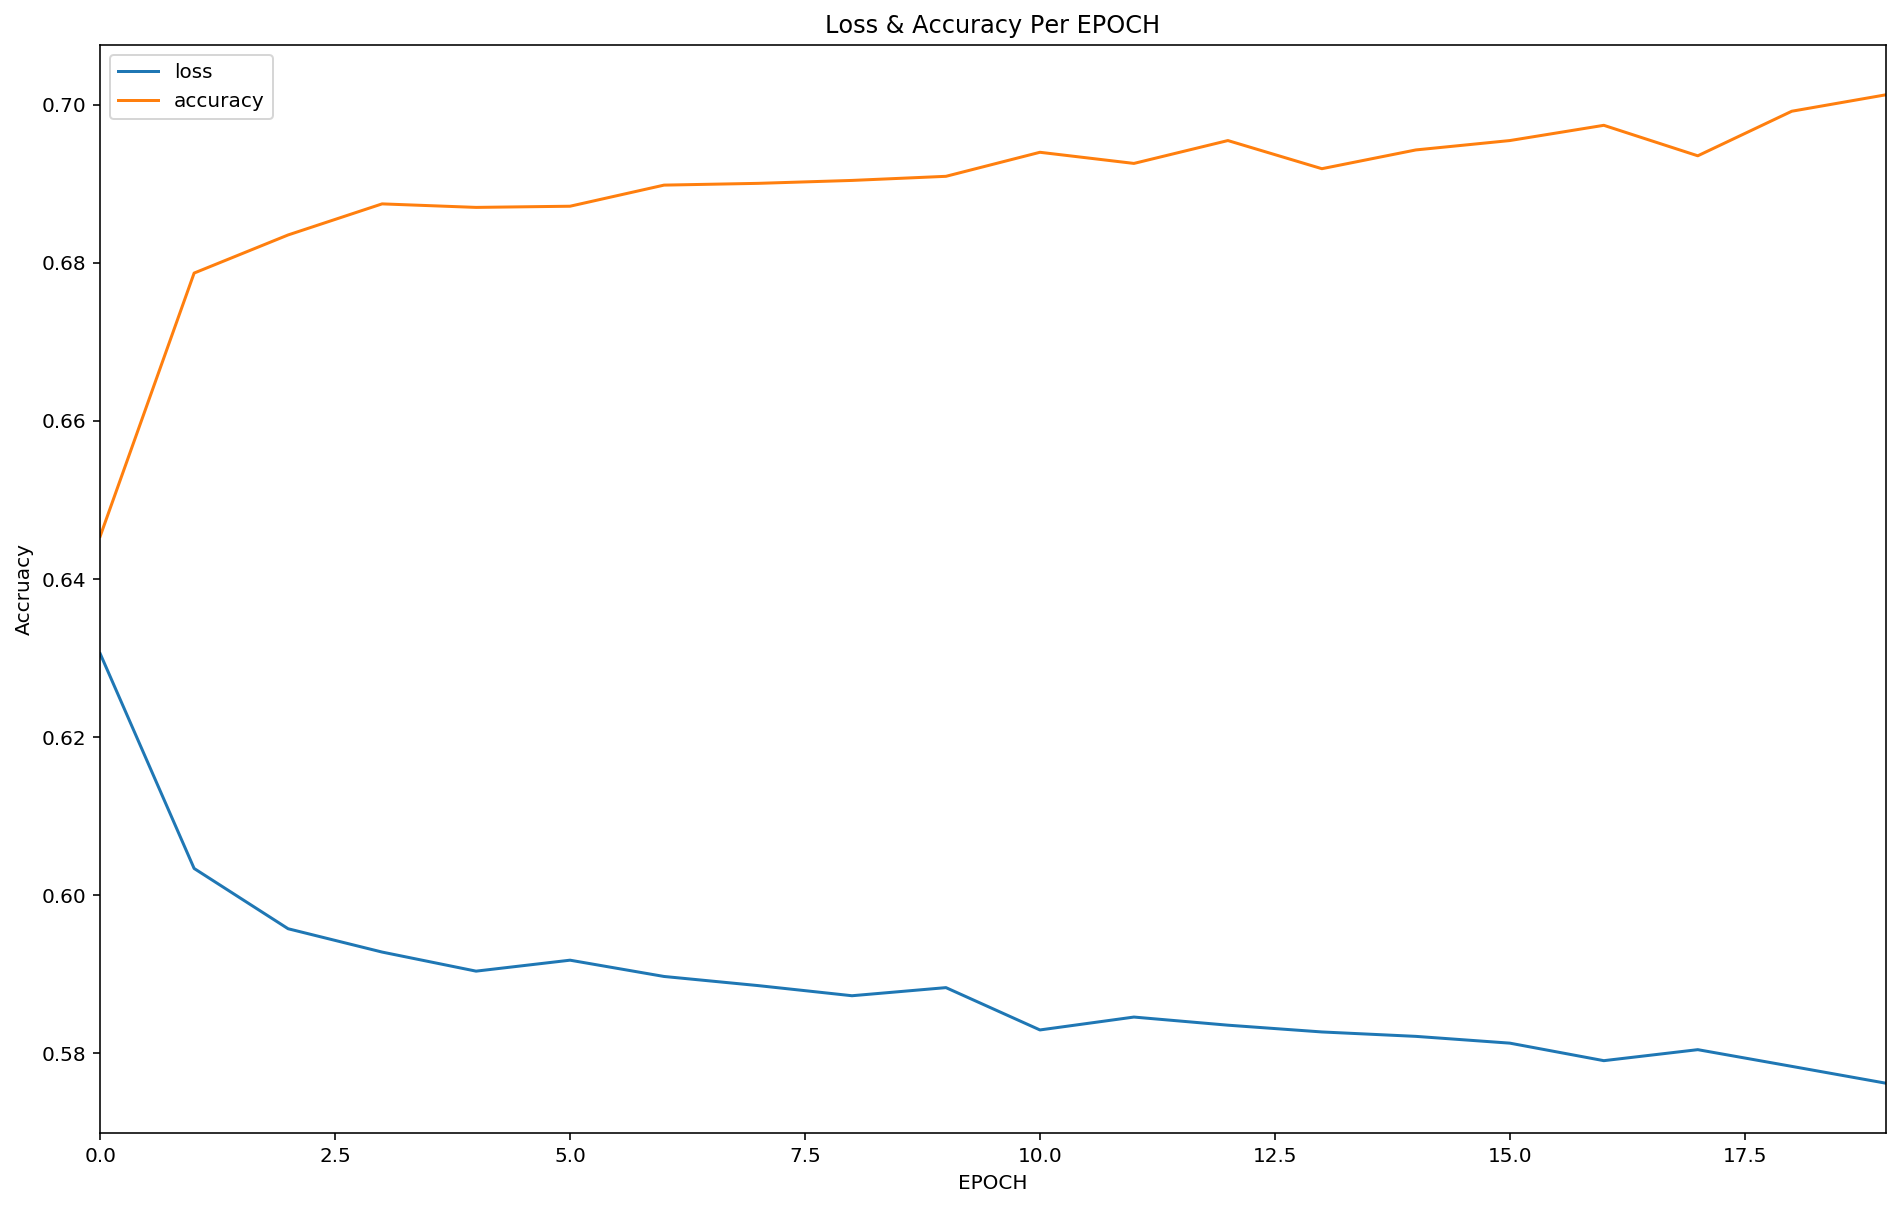

In [15]:
hyperband_accuracy_df[['loss', 'accuracy']].plot(figsize=(16,10))
plt.title('Loss & Accuracy Per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Accruacy')
plt.show()

## 2.2 KERAS TUNER - RANDOM SEARCH

The RandomSearch tuner randomly selects different combinations in order to find the best possible fit.

We can also "re-use" the HyperModel subclass created earlier.

In [18]:
random_tuner = RandomSearch(
    hypermodel,
    objective='accuracy',
    max_trials=20,
    seed=42, 
    project_name='weather_keras') # detailed logs, checkpoints in this folder

In [19]:
random_tuner.search(
    X_train.values,
    y_train.values.flatten(),
    epochs=20,
    validation_data=(X_test.values, y_test.values.flatten()),
)

Train on 10786 samples, validate on 2697 samples
Epoch 1/20
10786/10786 [==============================] - ETA: 3:37 - loss: 0.6971 - accuracy: 0.34 - ETA: 13s - loss: 0.7036 - accuracy: 0.4863 - ETA: 7s - loss: 0.7000 - accuracy: 0.494 - ETA: 4s - loss: 0.6941 - accuracy: 0.52 - ETA: 3s - loss: 0.6933 - accuracy: 0.52 - ETA: 2s - loss: 0.6898 - accuracy: 0.53 - ETA: 2s - loss: 0.6835 - accuracy: 0.55 - ETA: 2s - loss: 0.6781 - accuracy: 0.56 - ETA: 1s - loss: 0.6739 - accuracy: 0.57 - ETA: 1s - loss: 0.6681 - accuracy: 0.58 - ETA: 1s - loss: 0.6646 - accuracy: 0.59 - ETA: 1s - loss: 0.6620 - accuracy: 0.59 - ETA: 1s - loss: 0.6589 - accuracy: 0.60 - ETA: 0s - loss: 0.6535 - accuracy: 0.61 - ETA: 0s - loss: 0.6524 - accuracy: 0.61 - ETA: 0s - loss: 0.6494 - accuracy: 0.61 - ETA: 0s - loss: 0.6490 - accuracy: 0.61 - ETA: 0s - loss: 0.6453 - accuracy: 0.62 - ETA: 0s - loss: 0.6428 - accuracy: 0.62 - ETA: 0s - loss: 0.6412 - accuracy: 0.62 - ETA: 0s - loss: 0.6398 - accuracy: 0.62 - ETA: 

10786/10786 [==============================] - ETA: 1s - loss: 0.4962 - accuracy: 0.71 - ETA: 1s - loss: 0.5911 - accuracy: 0.68 - ETA: 1s - loss: 0.5667 - accuracy: 0.70 - ETA: 0s - loss: 0.5609 - accuracy: 0.70 - ETA: 0s - loss: 0.5728 - accuracy: 0.70 - ETA: 0s - loss: 0.5674 - accuracy: 0.70 - ETA: 0s - loss: 0.5787 - accuracy: 0.69 - ETA: 0s - loss: 0.5832 - accuracy: 0.69 - ETA: 0s - loss: 0.5857 - accuracy: 0.68 - ETA: 0s - loss: 0.5862 - accuracy: 0.68 - ETA: 0s - loss: 0.5858 - accuracy: 0.68 - ETA: 0s - loss: 0.5867 - accuracy: 0.68 - ETA: 0s - loss: 0.5871 - accuracy: 0.68 - ETA: 0s - loss: 0.5863 - accuracy: 0.68 - ETA: 0s - loss: 0.5865 - accuracy: 0.68 - ETA: 0s - loss: 0.5849 - accuracy: 0.68 - ETA: 0s - loss: 0.5868 - accuracy: 0.68 - ETA: 0s - loss: 0.5876 - accuracy: 0.68 - ETA: 0s - loss: 0.5875 - accuracy: 0.68 - ETA: 0s - loss: 0.5878 - accuracy: 0.68 - ETA: 0s - loss: 0.5868 - accuracy: 0.68 - ETA: 0s - loss: 0.5876 - accuracy: 0.68 - ETA: 0s - loss: 0.5875 - accu

In [20]:
random_params = random_tuner.get_best_hyperparameters()[0]

random_model = random_tuner.hypermodel.build(params)

random_model.fit(X.values, y.values.flatten(), epochs=20)

random_accuracy_df = pd.DataFrame(random_model.history.history)


Train on 13483 samples
Epoch 1/20
13483/13483 [==============================] - ETA: 3:57 - loss: 0.6896 - accuracy: 0.50 - ETA: 11s - loss: 0.6817 - accuracy: 0.5521 - ETA: 6s - loss: 0.6790 - accuracy: 0.579 - ETA: 4s - loss: 0.6765 - accuracy: 0.58 - ETA: 3s - loss: 0.6717 - accuracy: 0.59 - ETA: 2s - loss: 0.6621 - accuracy: 0.61 - ETA: 1s - loss: 0.6538 - accuracy: 0.62 - ETA: 1s - loss: 0.6474 - accuracy: 0.62 - ETA: 1s - loss: 0.6454 - accuracy: 0.63 - ETA: 1s - loss: 0.6430 - accuracy: 0.63 - ETA: 0s - loss: 0.6428 - accuracy: 0.63 - ETA: 0s - loss: 0.6419 - accuracy: 0.63 - ETA: 0s - loss: 0.6377 - accuracy: 0.64 - ETA: 0s - loss: 0.6342 - accuracy: 0.64 - ETA: 0s - loss: 0.6334 - accuracy: 0.64 - ETA: 0s - loss: 0.6307 - accuracy: 0.64 - ETA: 0s - loss: 0.6301 - accuracy: 0.64 - ETA: 0s - loss: 0.6296 - accuracy: 0.64 - ETA: 0s - loss: 0.6270 - accuracy: 0.65 - 2s 114us/sample - loss: 0.6242 - accuracy: 0.6537
Epoch 2/20
13483/13483 [==============================] - ETA: 1s

13483/13483 [==============================] - ETA: 2s - loss: 0.4909 - accuracy: 0.78 - ETA: 1s - loss: 0.5817 - accuracy: 0.69 - ETA: 0s - loss: 0.5871 - accuracy: 0.68 - ETA: 0s - loss: 0.5875 - accuracy: 0.68 - ETA: 0s - loss: 0.5922 - accuracy: 0.68 - ETA: 0s - loss: 0.5927 - accuracy: 0.68 - ETA: 0s - loss: 0.5921 - accuracy: 0.68 - ETA: 0s - loss: 0.5907 - accuracy: 0.68 - ETA: 0s - loss: 0.5899 - accuracy: 0.68 - ETA: 0s - loss: 0.5881 - accuracy: 0.68 - ETA: 0s - loss: 0.5881 - accuracy: 0.68 - ETA: 0s - loss: 0.5873 - accuracy: 0.68 - ETA: 0s - loss: 0.5858 - accuracy: 0.69 - ETA: 0s - loss: 0.5854 - accuracy: 0.69 - ETA: 0s - loss: 0.5863 - accuracy: 0.69 - ETA: 0s - loss: 0.5853 - accuracy: 0.69 - ETA: 0s - loss: 0.5833 - accuracy: 0.69 - ETA: 0s - loss: 0.5811 - accuracy: 0.69 - ETA: 0s - loss: 0.5817 - accuracy: 0.69 - ETA: 0s - loss: 0.5812 - accuracy: 0.69 - 1s 73us/sample - loss: 0.5812 - accuracy: 0.6950
Epoch 18/20
13483/13483 [==============================] - ETA: 

In [21]:
random_tuner.results_summary()

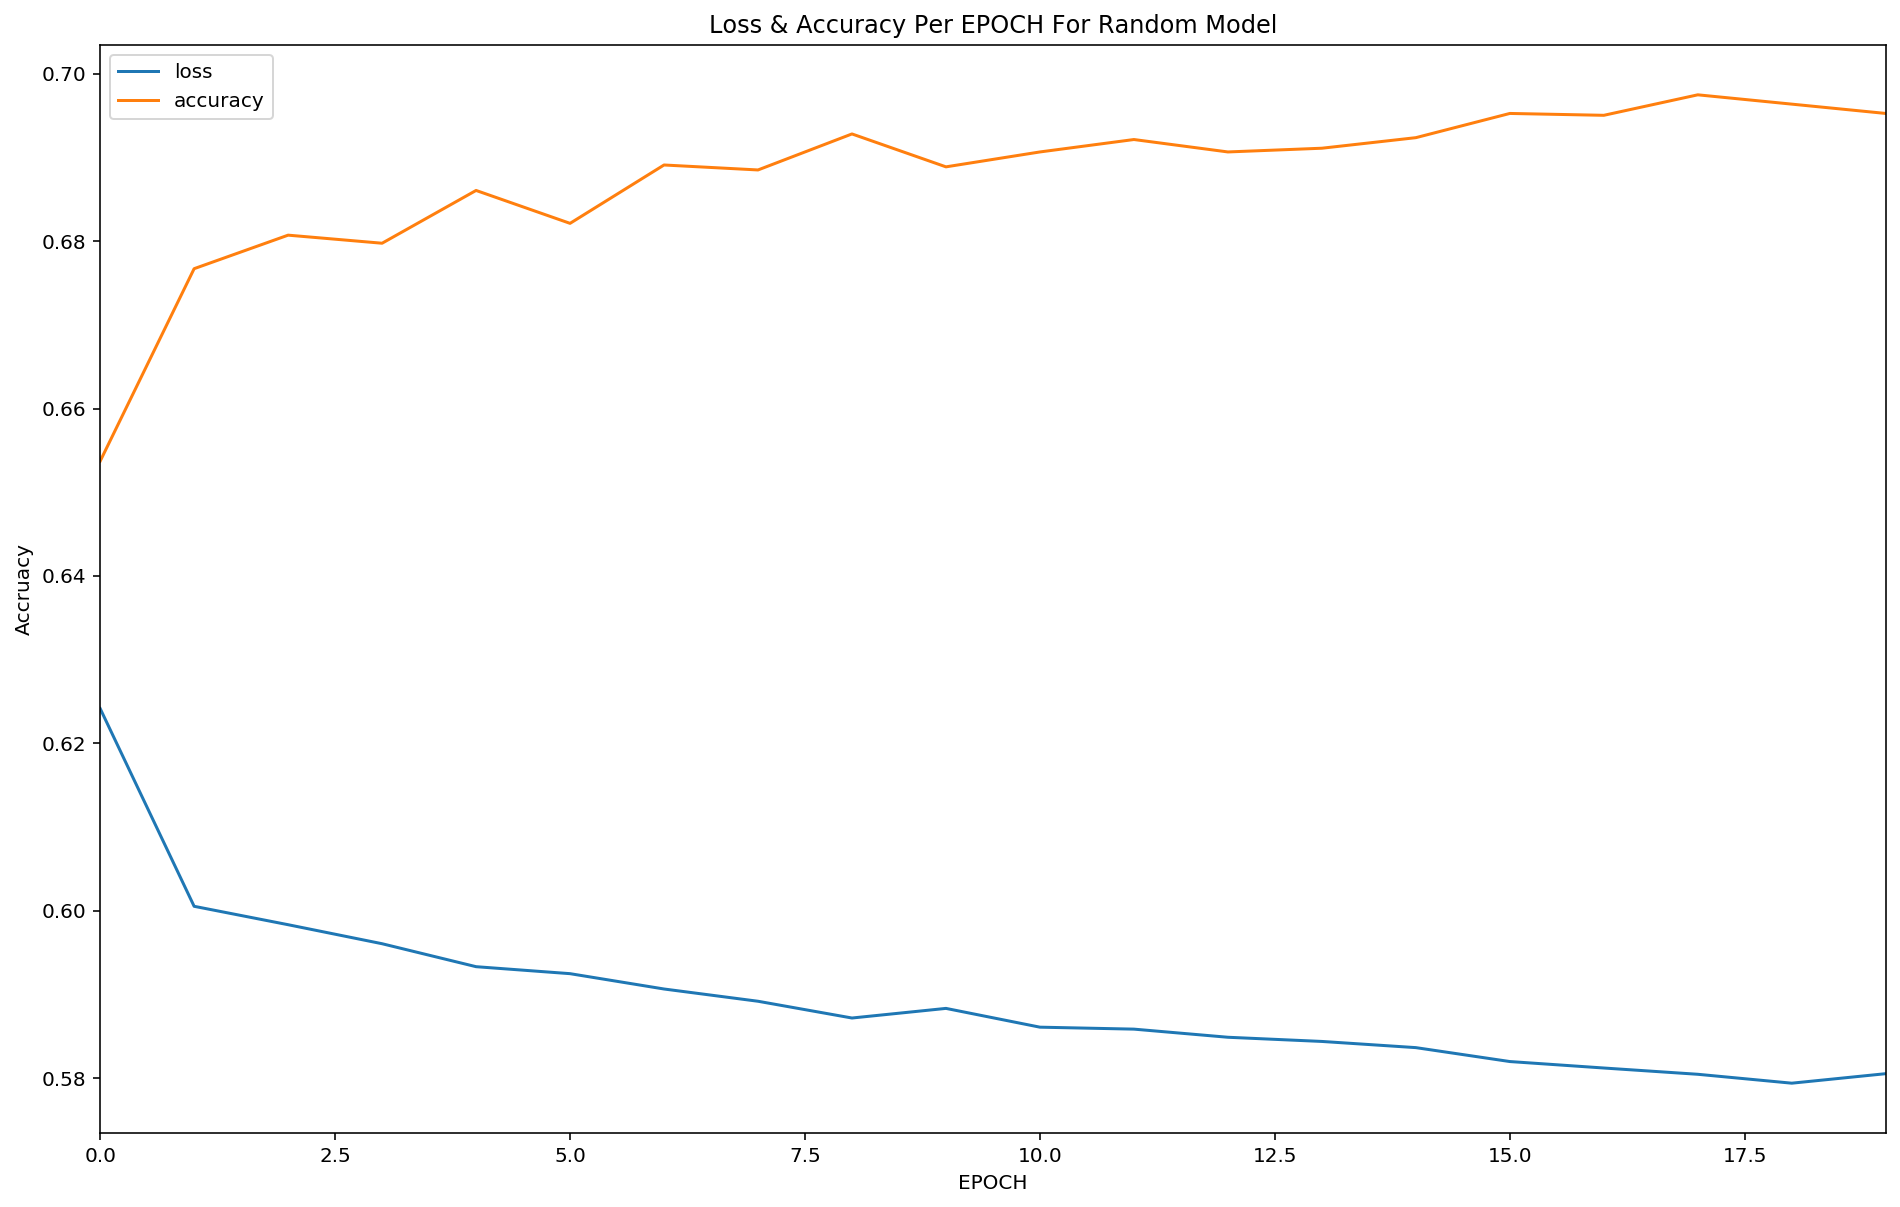

In [22]:
random_accuracy_df[['loss', 'accuracy']].plot(figsize=(16,10))
plt.title('Loss & Accuracy Per EPOCH For Random Model')
plt.xlabel('EPOCH')
plt.ylabel('Accruacy')
plt.show()

# END NOTE:
While Keras Tuner was much faster than the scikit-learn/GridSearch option, the accuracy levels could not go above 0.7. There's probably more to the art of using Keras Tuner that I'm unaware of, but I'll leave future efforts to a more suitable dataset.    